<font size="5">Imports</font>

In [60]:
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten
import keras.layers.normalization as BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt 
from PIL import ImageEnhance, Image, ImageOps

<font size="5">Preprocessings</font>  ---- Grayscale and saturation

In [79]:
imgfolder     = 'Images/'
coloredFolder = 'colored/'
grayFolder    = 'gray/'
resultsFolder = 'results/'

#converts the image to grayscale
def convertToGrayscale(name,img):
    gray_image = ImageOps.grayscale(img)
    gray_image.save(name)

#changes the saturation of the image
def changeSaturation(name, img):
    convert = ImageEnhance.Color(img)
    newImage = convert.enhance(1.5)  # <---- Change here to increase or lower saturation 1 is default (100%) 1.5 is 150% increased
    newImage.save(name)


# Change the imgName to whatever image in the colored you want to process
imgName = 'woman2.png'

# Dont touch
imgPath = imgfolder + coloredFolder + imgName
img = Image.open(r''+imgPath)
saveAsGray = imgfolder + grayFolder + imgName
saveAsSaturated = imgfolder + coloredFolder + 'saturated' + imgName

# Comment out or in whatever preprocessing step you want to do
convertToGrayscale(saveAsGray,img)
changeSaturation(saveAsSaturated,img) 


---- Gamma correction - outputs 2 new black and white images where 1 has increased- and the other has lowered gamma

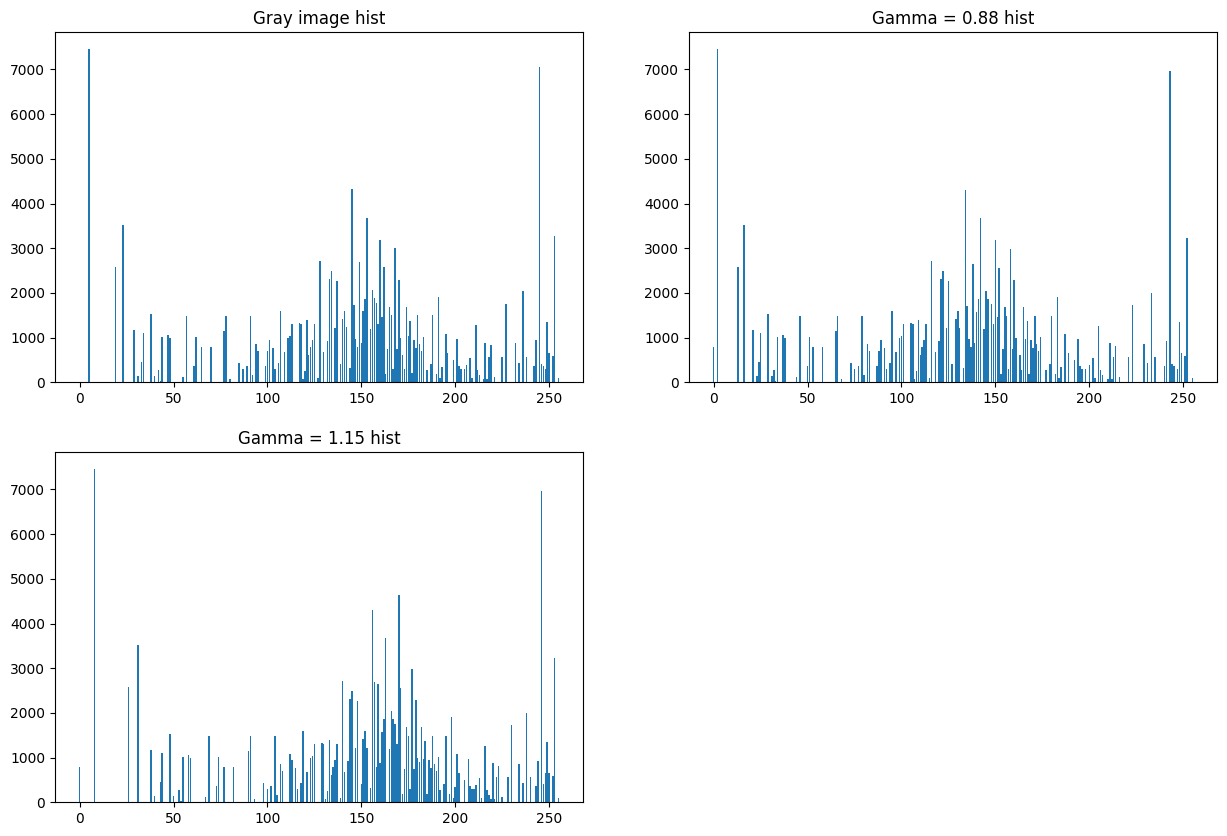

In [80]:
#Change image name. You can also change gamma1 and 2 to whatever value you want. 1.0 is default
imageName = 'woman2.png'
gamma1 = 0.88
gamma2 = 1.15
path = imgfolder + coloredFolder + imageName #Edit what folder the image is in if you load a colored or gray image


# Dont touch
gray_img = Image.open(path).convert("LA") 
saveGamma1As = imgfolder + grayFolder + 'gamma1.png'
saveGamma2As = imgfolder + grayFolder + 'gamma2.png'

row = gray_img.size[0]
col = gray_img.size[1]
result_img1 = Image.new("L", (row, col))
result_img2 = Image.new("L", (row, col))
for x in range(1 , row):
    for y in range(1, col):
        value = pow(gray_img.getpixel((x,y))[0]/255,(1/gamma1))*255
        if value >= 255 :
            value = 255
        result_img1.putpixel((x,y), int(value))
        value = pow(gray_img.getpixel((x,y))[0]/255,(1/gamma2))*255
        if value >= 255 :
            value = 255
        result_img2.putpixel((x,y), int(value))
result_img1.save(saveGamma1As)
result_img2.save(saveGamma2As)

plt.figure(figsize=(15,10))
y = gray_img.histogram()
y = y[0:256]
x = np.arange(len(y))
plt.subplot(221)
plt.title("Gray image hist")
plt.bar(x, y)

plt.subplot(222)
y = result_img1.histogram()
x = np.arange(len(y))
plt.title("Gamma = 0.88 hist")
plt.bar(x, y)

plt.subplot(223)
y = result_img2.histogram()
x = np.arange(len(y))
plt.title("Gamma = 1.15 hist")
plt.bar(x, y)

fig = plt.gcf()
plt.show()

fig.savefig('histogram.png')

<font size="5">Training</font>

In [81]:
#Get image, Change the path and name to whatever image you want to train the nn on
imgName = 'woman2.png'
imgPath = imgfolder + coloredFolder + imgName

# Dont edit
image = tf.keras.utils.img_to_array(tf.keras.utils.load_img(imgPath))
image = np.array(image, dtype=float)

X = rgb2lab(1.0/255*image)[:,:,0]
Y = rgb2lab(1.0/255*image)[:,:,1:]
Y /= 128
X = X.reshape(1, 400, 400, 1)
Y = Y.reshape(1, 400, 400, 2)

In [73]:
# Building the neural network
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.compile(optimizer='rmsprop',loss='mse')

In [82]:
#Train the neural network
model.fit(x=X, y=Y, batch_size=1, epochs=1000) #Change the epochs to affect the amount of times the nn is trained

Epoch 1/1000
1/1 [==============================] - 0s 248ms/step - loss: 0.0367
Epoch 2/1000
1/1 [==============================] - 0s 217ms/step - loss: 0.0187
Epoch 3/1000
1/1 [==============================] - 0s 221ms/step - loss: 0.0084
Epoch 4/1000
1/1 [==============================] - 0s 208ms/step - loss: 0.0069
Epoch 5/1000
1/1 [==============================] - 0s 213ms/step - loss: 0.0065
Epoch 6/1000
1/1 [==============================] - 0s 211ms/step - loss: 0.0062
Epoch 7/1000
1/1 [==============================] - 0s 247ms/step - loss: 0.0059
Epoch 8/1000
1/1 [==============================] - 0s 249ms/step - loss: 0.0057
Epoch 9/1000
1/1 [==============================] - 0s 208ms/step - loss: 0.0058
Epoch 10/1000
1/1 [==============================] - 0s 225ms/step - loss: 0.0060
Epoch 11/1000
1/1 [==============================] - 0s 242ms/step - loss: 0.0058
Epoch 12/1000
1/1 [==============================] - 0s 232ms/step - loss: 0.0055
Epoch 13/1000
1/1 [======

<font size="5">Testing</font>

In [89]:
# The NN is now trained on that img, test it by load whatever image you want, (can take colored as it will make them gray)
imgName = 'gamma1.png'
imgPath = imgfolder + grayFolder + imgName

# Dont edit
image = tf.keras.utils.img_to_array(tf.keras.utils.load_img(imgPath))
image = np.array(image, dtype=float)

X = rgb2lab(1.0/255*image)[:,:,0]
Y = rgb2lab(1.0/255*image)[:,:,1:]
Y /= 128
X = X.reshape(1, 400, 400, 1)
Y = Y.reshape(1, 400, 400, 2)

print(model.evaluate(X, Y, batch_size=1))
output = model.predict(X)
output *= 128

# Output colorizations
cur = np.zeros((400, 400, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0]
imsave(imgfolder + resultsFolder + imgName, lab2rgb(cur))

1/1 [==============================] - 0s 41ms/step - loss: 0.0068
0.006774600129574537
1/1 [==============================] - 0s 42ms/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
